<a href="https://colab.research.google.com/github/iamatul1214/Tensorflow_Certification_Preparation/blob/main/04_transfer_learning_with_tensorflow_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Here we will see transfer learning on the food dataset

In [1]:
import os
Root = "/content/drive/MyDrive/Tensorflow certifications work"
os.chdir(Root)
!pwd

/content/drive/MyDrive/Tensorflow certifications work


## Becoming one with data

In [2]:
try:
  if os.path.exists(os.path.join(os.getcwd(),"10_food_classes_10_percent.zip")):
    print("file already exists, hence, skipping the download of zip file and unzipping of it....")
  else:
    ! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

    import zipfile
    zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
    zip_ref.extractall()
    zip_ref.close()
except Exception as e:
  print(e) 

file already exists, hence, skipping the download of zip file and unzipping of it....


In [3]:
## checking images in each folder

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

### As we observed in above cell, we have 75 images only for each class, and that's why we will transfer learning here and see how in less data we can train a model properly.


### Let's create imagedatagenerators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

## The hyperparameters in tensorflow as generally defined in upper case

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size = IMG_SIZE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMG_SIZE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")

Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## Setting up callbacks

callbacks are extra functionality you can add to your models to be performed during  or after training. Some of the most popular callbacks are-:
* Tracking the experiments using tensorboard
* Model checkpointing
* Earlystopping checkpoint

In [5]:
## creating a tensorboard callback but functionizing it because we need to create a new one for each model

def create_tensorboard_callback(dir_name,experiment_name):
  import datetime
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H&M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving the tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating model using tensorflow hub

### Till now we have created models from scratch but now we will use tensorflow hub and use transfer learning to add some custom layers to our already created models.


### We are using imagenet/resnet_v2_50 --> https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

### We are also using https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
### Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
## Importing the dependencies
import tensorflow as tf
import tensorflow_hub as hub

In [8]:
## Let's create a create_model() function to create a model from url

def create_model(model_url, num_of_classes=10):
  """
  Takes a tensorflow hub url and creates the model out of it

  Args:
  model_url (str): A tensorflow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layer. default is 10.

  Returns:
  An uncompiled Keras Sequential model model_url as feature extractor layer and Dense output layer as number of classes neurons.

  """
  ## Dwonload the pretrained model and save it for keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SIZE+(3,))
  ## create your own model

  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_of_classes, activation = "softmax", name="Output_layer")
  ])

  return model

In [9]:
## Create the resnet tensorflow hub model feature_extraction first

resnet_model = create_model(resnet_url,num_of_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
## compiling the model
resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [13]:
## fitting the model on training data
history_resnet = resnet_model.fit(train_data_10_percent, epochs = 5, 
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data = test_data_10_percent, 
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorboard_hub", experiment_name="Resnet50V2")])

Saving the tensorboard log files to: tensorboard_hub/Resnet50V2/20220929-10&M48
Epoch 1/5
24/24 [==============================] - 2432s 104s/step - loss: 1.9656 - accuracy: 0.3493 - val_loss: 1.2014 - val_accuracy: 0.6268
Epoch 2/5
24/24 [==============================] - 19s 820ms/step - loss: 0.9044 - accuracy: 0.7200 - val_loss: 0.8607 - val_accuracy: 0.7296
Epoch 3/5
24/24 [==============================] - 19s 824ms/step - loss: 0.6252 - accuracy: 0.8187 - val_loss: 0.7773 - val_accuracy: 0.7440
Epoch 4/5
24/24 [==============================] - 19s 827ms/step - loss: 0.4896 - accuracy: 0.8680 - val_loss: 0.7005 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 19s 829ms/step - loss: 0.3814 - accuracy: 0.9160 - val_loss: 0.6866 - val_accuracy: 0.7764


## !Wow we saw that using transfer learning with just 75 images of each class and we can see the huge difference in the validation accuracy compared to model creating from scratch.

### Here we have used the transfer learning in the form of feature extractor which means we didn't do changes in any of the layers, we just changed the output layer becuase resnet50V2 was trained for 1000 classes, and we needed only 10 classes.

In [14]:
### Let's create a function for plotting the loss curve
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation losses.
    
    Args:
        history: Tensorflow history object
        
    Returns:
        plots of training and validtion loss and accuracy metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    ## plot the loss
    plt.figure()
    plt.plot(epochs, loss, label = "training loss")
    plt.plot(epochs, val_loss, label = "validaiton loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    ## Plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training accuracy")
    plt.plot(epochs, val_accuracy, label = "validaiton accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

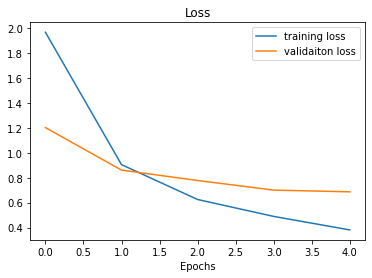

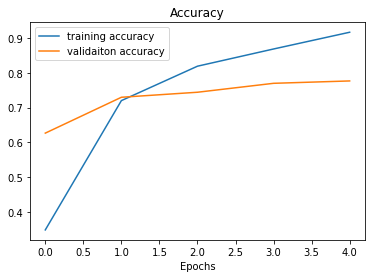

In [15]:
plot_loss_curves(history_resnet)

### Now let's create a model using efficient net model and fit the data

In [16]:
efficient_net_model = create_model(model_url=efficientnet_url)
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
efficient_net_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                            optimizer = tf.keras.optimizers.Adam(),
                            metrics = ["accuracy"])

In [18]:
history_efficientNet = efficient_net_model.fit(train_data_10_percent,
                                               epochs = 5,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data = test_data_10_percent,
                                               validation_steps=len(test_data_10_percent),
                                               callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name="Efficient_Net")])

Saving the tensorboard log files to: tensorflow_hub/Efficient_Net/20220929-11&M26
Epoch 1/5
24/24 [==============================] - 33s 1s/step - loss: 1.8209 - accuracy: 0.4307 - val_loss: 1.2718 - val_accuracy: 0.7304
Epoch 2/5
24/24 [==============================] - 19s 826ms/step - loss: 1.0423 - accuracy: 0.7733 - val_loss: 0.8550 - val_accuracy: 0.8160
Epoch 3/5
24/24 [==============================] - 19s 812ms/step - loss: 0.7522 - accuracy: 0.8387 - val_loss: 0.6934 - val_accuracy: 0.8480
Epoch 4/5
24/24 [==============================] - 19s 802ms/step - loss: 0.6082 - accuracy: 0.8680 - val_loss: 0.6108 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 19s 816ms/step - loss: 0.5106 - accuracy: 0.8960 - val_loss: 0.5533 - val_accuracy: 0.8668


### Looks like Efficient net is working better than the Resnet. To find more read the documentation of Efficient net

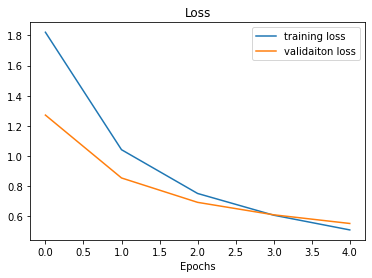

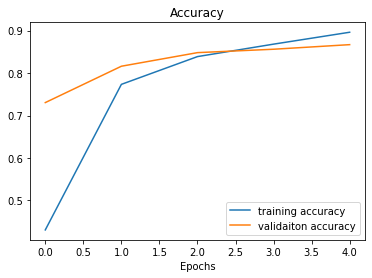

In [19]:
plot_loss_curves(history_efficientNet)

## Different types of transfer learning
* **As Is** Here we use the model as it is and don't do any changes. Eg-> Using Imagenet model of 101 classes for our 101 classes.
* **Feature extraction** Here we just change the output layer of the existing model. That's why we get all the features and we amend the output as per our classes/requirement. Eg-> using Imagenet model of 101 classes for our 10 classes.
* **Fine tuning** Here, we unfreeze some of the pretrained layers, and train them again, we can even introduce more layers.

## Comparing our models results using TensorBoard.

#### Remember that uploaded data on tensorboard.dev is available on public basis so please be ware before uploading.

In [20]:
## Uploading to tensorboard.dev
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs Resnet50V2" \
    --description "comparing two different models for transfer learning" \
    --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=KNjXDdQaSwAPat7xW7svqnsaPQS2DD&prompt=consent&access_type=off

In [21]:
!tensorboard dev list

https://tensorboard.dev/experiment/812K6cK2QbeaxnvA8CEv1w/
	Name                 EfficientNetB0 vs Resnet50V2
	Description          comparing two different models for transfer learning
	Id                   812K6cK2QbeaxnvA8CEv1w
	Created              2022-09-29 11:10:35 (5 minutes ago)
	Updated              2022-09-29 11:10:38 (5 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  4074964
Total: 1 experiment(s)
